9/7/21:
- (Done) Try tighter smoke_pixel_threshold (10 vs. 250)
- Try different imbalanced-dataset weighting methods
- Try Yash loss
- Label positive images with missing labels
- Re-run experiments and average results
- Generate time-to-detection human experiment

ASAP:
- (DONE) Check out structure, JEEP fires - most are nighttime
- (DONE) See if individual fires are messing it up

Concepts:
- Scale info - revisit FPN
- "Flipping back & forth images" - motion, optical flow?
- Uncertainty in model

Easy Stuff:
- 100Resize on object detection models
- Dropout20
- Weight decay
- No image preds
- ViViT, CaiT

In [8]:
# import gc
# import torch

# gc.collect()
# torch.cuda.empty_cache()

In [1]:
import matplotlib.pyplot as plt
import src.util_fns as util_fns
import pickle
import numpy as np
import torchmetrics
import torch, torchvision
import torch.nn as nn
import tensorboard as tb
import torch.nn.functional as F
import cv2
import os
import torchvision.transforms as T
from pathlib import Path
import xml.etree.ElementTree as ET
import matplotlib.image as mpimg
import datetime
import sklearn.metrics
from sklearn.model_selection import train_test_split
import transformers
from efficientnet_pytorch import EfficientNet
import csv
from torchvision.models.detection.backbone_utils import mobilenet_backbone, resnet_fpn_backbone
import shutil
# from model_components import *

In [2]:
metadata = pickle.load(open('./data/metadata.pkl', 'rb'))

raw_data_path = '/userdata/kerasData/data/new_data/raw_images/'
raw_labels_path = '/userdata/kerasData/data/new_data/drive_clone/'
labels_path = '/root/pytorch_lightning_data/drive_clone_numpy/'

example = '20180603_FIRE_smer-tcs8-mobo-c/1528058095_+00840'

In [29]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('Device Name: ', str(torch.cuda.get_device_name(0)) if torch.cuda.is_available() else 'CPU')

Device Name:  GeForce RTX 2080 Ti


In [3]:
%load_ext autoreload
%autoreload 2

# Scratch

In [42]:
m = mobilenet_backbone('mobilenet_v3_large',pretrained=False,fpn=True, trainable_layers=6)
# m.body = nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
# m.backbone
m.body['0'][0]

Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

# Re-Calculate Test Metrics

In [3]:
def recalculate_test_metrics(dir_str):
    image_preds = np.loadtxt(dir_str, delimiter=',', dtype=str)

    fires = {}
    gt = []
    preds = []

    positive_preds_dict = {} # Holds positive predictions for each fire
    negative_preds_dict = {} # Holds negative predictions for each fire
    positive_times_dict = {} # Holds timestamps of positives for each fire

    for (image_name, image_pred, loss) in image_preds:
        fire_name = util_fns.get_fire_name(image_name)

        if image_pred == 'True' or image_pred == '1':
            image_pred = 1
        else:
            image_pred = 0

        if fire_name not in fires:
            fires[fire_name] = []
            positive_preds_dict[fire_name] = []
            negative_preds_dict[fire_name] = []
            positive_times_dict[fire_name] = []

        fires[fire_name].append(image_pred)
        gt.append(util_fns.get_ground_truth_label(image_name))
        preds.append(image_pred)

        if util_fns.get_ground_truth_label(image_name) == 0:
            negative_preds_dict[fire_name].append(image_pred)
        else:
            positive_preds_dict[fire_name].append(image_pred)
            positive_times_dict[fire_name].append(util_fns.image_name_to_time_int(image_name))


    acc = sklearn.metrics.accuracy_score(gt, preds)
    f1 = sklearn.metrics.f1_score(gt, preds)
    precision = sklearn.metrics.precision_score(gt, preds)
    recall = sklearn.metrics.recall_score(gt, preds)
    avg_ttd, med_ttd, std_ttd = util_fns.calculate_time_to_detection_stats(positive_preds_dict, positive_times_dict)

    data = [acc, f1, precision, recall, avg_ttd]

    acc = str(round(acc*100, 2))
    f1 = str(round(f1*100, 2))
    precision = str(round(precision*100, 2))
    recall = str(round(recall*100, 2))
    avg_ttd = str(round(avg_ttd, 2))

    print(acc+'/'+f1+'/'+precision+'/'+recall+'/'+avg_ttd)
    
    return data


In [4]:
# base_dir = './saved_logs/versions_319-324/'
base_dir = './lightning_logs/'

all_folders = [folder.stem for folder in filter(Path.is_dir, Path(base_dir).iterdir())]

for dir_str in all_folders:
    print('\n=== '+dir_str+' ===')
    version_folders = [folder.stem for folder in filter(Path.is_dir, Path(base_dir+dir_str).iterdir())]
    
    raw_data = []
    for ver_str in version_folders:
        p = base_dir+dir_str+'/'+ver_str+'/image_preds.csv'
        
        if Path(p).exists():
            # print(ver_str)
            d = recalculate_test_metrics(p)
            raw_data.append(d)
    
    if len(raw_data) > 0:
        all_data_mean = np.array(raw_data).mean(0)
        acc_mean = str(round(all_data_mean[0]*100, 2))
        f1_mean = str(round(all_data_mean[1]*100, 2))
        precision_mean = str(round(all_data_mean[2]*100, 2))
        recall_mean = str(round(all_data_mean[3]*100, 2))
        avg_ttd_mean = str(round(all_data_mean[4], 2))

        print('\nAvg:',acc_mean+'/'+f1_mean+'/'+precision_mean+'/'+recall_mean+'/'+avg_ttd_mean)
        
        all_data_sd = np.array(raw_data).std(0)
        acc_sd = str(round(all_data_sd[0]*100, 2))
        f1_sd = str(round(all_data_sd[1]*100, 2))
        precision_sd = str(round(all_data_sd[2]*100, 2))
        recall_sd = str(round(all_data_sd[3]*100, 2))
        avg_ttd_sd = str(round(all_data_sd[4], 2))
        
        print('Std:',acc_sd+'/'+f1_sd+'/'+precision_sd+'/'+recall_sd+'/'+avg_ttd_sd)
        
        print(acc_mean+' & '+f1_mean+' & '+precision_mean+' & '+recall_mean+' & '+avg_ttd_mean)
#         print('&      &      & ('+acc_sd+') & ('+f1_sd+') & ('+precision_sd+') & ('+recall_sd+') & ('+avg_ttd_sd+') \\\\')
#         print(acc_mean+' ('+acc_sd+') & '+f1_mean+' ('+f1_sd+') & '+precision_mean+' ('+precision_sd+') & '+recall_mean+' ('+recall_sd+') & '+avg_ttd_mean+' ('+avg_ttd_sd+')')
#         print("\\shortstack{{{}\\\\({})}} & \\shortstack{{{}\\\\({})}} & \\shortstack{{{}\\\\({})}} & \\shortstack{{{}\\\\({})}} & \\shortstack{{{}\\\\({})}}".format(acc_mean, acc_sd, f1_mean, f1_sd, precision_mean, precision_sd, recall_mean, recall_sd, avg_ttd_mean, avg_ttd_sd))

            
            
            


=== Final_MobileNetFPN_LSTM_SpatialViT_NoXML_ImageWeight5 ===
80.62/80.52/80.07/80.98/2.83
79.12/79.25/77.93/80.62/2.29
80.42/79.77/81.59/78.03/2.74
80.06/79.86/79.8/79.93/2.25
81.51/81.31/81.28/81.34/2.17

Avg: 80.35/80.14/80.13/80.18/2.46
Std: 0.77/0.71/1.3/1.17/0.27
80.35 & 80.14 & 80.13 & 80.18 & 2.46

=== Final_MobileNet_LSTM_SpatialViT_03Thresh_Test ===
81.85/79.42/90.39/70.82/4.9

Avg: 81.85/79.42/90.39/70.82/4.9
Std: 0.0/0.0/0.0/0.0/0.0
81.85 & 79.42 & 90.39 & 70.82 & 4.9

=== Final_MobileNetFPN_LSTM_SpatialViT_NoXML ===
81.45/79.26/88.64/71.67/4.13
79.62/77.89/84.06/72.56/3.73
80.68/78.86/85.96/72.85/3.75
80.2/77.61/88.08/69.36/4.88
82.05/80.6/86.57/75.39/3.7

Avg: 80.8/78.84/86.66/72.37/4.04
Std: 0.86/1.07/1.62/1.95/0.45
80.8 & 78.84 & 86.66 & 72.37 & 4.04

=== Final_MobileNetFPN_LSTM_SpatialViT_Mislabeled ===
79.36/77.12/85.36/70.34/4.55
79.92/77.51/86.92/69.93/4.52
79.94/77.78/86.02/70.98/3.83
78.22/76.1/83.23/70.09/4.12
81.55/79.75/87.22/73.45/3.37

Avg: 79.8/77.65/85.75/

# Generate ViBE

In [27]:
all_fires = list(metadata['fire_to_images'].keys())
complete_fires = []

In [ ]:
save_path = '/userdata/kerasData/data/new_data/raw_images_mog/'

for j, fire in enumerate(all_fires):
    if fire in complete_fires: continue
    os.makedirs(save_path + fire, exist_ok=True)
    print(j, fire)
    
    for i, cur_image_name in enumerate(metadata['fire_to_images'][fire]):
        if i == 0:
            cur_image_rgb = cv2.imread(raw_data_path+'/'+cur_image_name+'.jpg')
            continue

        prev_image_name = metadata['fire_to_images'][fire][i-1]
        prev_image_rgb = cur_image_rgb

        cur_image_rgb = cv2.imread(raw_data_path+'/'+cur_image_name+'.jpg')

        mog = cv2.createBackgroundSubtractorMOG2()
        
        output = mog.apply(prev_image_rgb)
        output = mog.apply(cur_image_rgb)
        
        np.save(save_path + cur_image_name + '.npy', output)
#         plt.imshow(rgb)
#         break
    
    complete_fires.append(fire)
#     break
        
        

    


0 20160722_FIRE_mw-e-mobo-c
1 20190922_FIRE_ml-w-mobo-c
2 20210113_Borderfire_mlo-s-mobo-c
3 20200521_VEGMGMT_wc-e-mobo-c
4 20170520_FIRE_lp-s-iqeye
5 20201205_typical-range-fire_sclm-e-mobo-c
6 20171016_FIRE_sdsc-e-mobo-c
7 20160718_FIRE_mg-s-iqeye
8 20190620_FIRE_smer-tcs9-mobo-c
9 20190716_FIRE_mg-n-mobo-c
10 20200521_FIRE_om-n-mobo-c
11 20180727_FIRE_bh-n-mobo-c
12 20180919_FIRE_rm-e-mobo-c
13 20180728_FIRE_rm-w-mobo-c
14 20170627_FIRE_lp-n-iqeye
15 20180727_FIRE_mg-w-mobo-c
16 20190810_SantaFire_rm-w-mobo
17 20200615_Rainbow_rm-e-mobo-c
18 20190715_MLOSouth2_lo-s-mobo-c
19 20170722_FIRE_bm-n-mobo-c
20 20201216_ChaparralFire_sm-n-mobo-c
21 20191006_FIRE_lp-e-mobo-c
22 20200813_SkylineFire_sp-n-mobo-c
23 20200812_LakeFire_dwpgm-n-mobo-c
24 20180706_West_lp-n-mobo-c
25 20190716_Riverfire_rm-w-mobo-c
26 20180602_FIRE_smer-tcs9-mobo-c
27 20201208_FIRE_om-s-mobo-c
28 20200829_inside-Mexico_cp-s-mobo-c
29 20170613_FIRE_bh-w-mobo-c
30 20180603_FIRE_smer-tcs9-mobo-c
31 20190924_FIRE_pi-w-m

In [32]:
fire = '20190610_FIRE_bh-w-mobo-c'
image_name = '20190610_FIRE_bh-w-mobo-c/1560199876_+01740'

# for image_name in metadata['fire_to_images'][fire]:


s = cv2.createBackgroundSubtractorMOG2()
# s = cv2.createBackgroundSubtractorKNN()



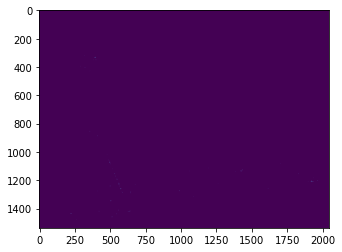

In [19]:
image_name = metadata['fire_to_images'][fire][38]
image = cv2.imread(raw_data_path+'/'+image_name+'.jpg')
image = s.apply(image)

plt.imshow(image)

# Generate Flow

In [4]:
all_fires = list(metadata['fire_to_images'].keys())
complete_fires = []

In [ ]:
save_path = '/userdata/kerasData/data/new_data/raw_images_flow/'

for j, fire in enumerate(all_fires):
    if fire in complete_fires: continue
    os.makedirs(save_path + fire, exist_ok=True)
    print(j, fire)
    
    for i, cur_image_name in enumerate(metadata['fire_to_images'][fire]):
        if i == 0:
            continue

        prev_image_name = metadata['fire_to_images'][fire][i-1]

        cur_image_rgb = cv2.imread(raw_data_path+'/'+cur_image_name+'.jpg')
        prev_image_rgb = cv2.imread(raw_data_path+'/'+prev_image_name+'.jpg')

        cur_image = cv2.cvtColor(cur_image_rgb,cv2.COLOR_BGR2GRAY)
        prev_image = cv2.cvtColor(prev_image_rgb,cv2.COLOR_BGR2GRAY)

        flow = cv2.calcOpticalFlowFarneback(prev_image, cur_image, None, 0.5, 3, 15, 3, 5, 1.2, 0)

        hsv = np.zeros_like(cur_image_rgb)
        hsv[...,1] = 255

        mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
        hsv[...,0] = ang*180/np.pi/2
        hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
        rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)
        
        np.save(save_path + cur_image_name + '.npy', rgb)
#         plt.imshow(rgb)
#         break
    
    complete_fires.append(fire)
#     break
        
        

    


0 20160722_FIRE_mw-e-mobo-c
1 20190922_FIRE_ml-w-mobo-c
2 20210113_Borderfire_mlo-s-mobo-c


# Inference Time

In [20]:
# Source: https://towardsdatascience.com/the-correct-way-to-measure-inference-time-of-deep-neural-networks-304a54e5187f
model_type_list = ["RawToTile_ObjectDetection"]

model_list = nn.ModuleList()
for model_type in model_type_list:
    model_list.append(globals()[model_type](
                     tile_embedding_size=1280,
                     num_tiles=40,
                     num_tiles_height=5,
                     num_tiles_width=8,
                     series_length=2,
                     backbone_size='maskrcnn'))

device = torch.device("cuda")
model_list.to(device)


dummy_input = torch.randn(1,1,3,1040,1856,dtype=torch.float).to(device)
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
repetitions = 300
timings=np.zeros((repetitions,1))

bbox_label = [[{"boxes": torch.zeros((0, 4), dtype=torch.float32).to(device),
                                  "labels": torch.zeros(0, dtype=torch.int64).to(device),
                                  "area": torch.zeros(0, dtype=torch.float32).to(device),
               "masks": torch.zeros((0, 1040, 1856), dtype=torch.uint8).to(device)}]]

# GPU-WARM-UP
for _ in range(10):
    outputs = None
    x = dummy_input
    for model in model_list:
        outputs, x = model(x, tile_outputs=outputs, bbox_labels=bbox_label)

# MEASURE PERFORMANCE
with torch.no_grad():
    for rep in range(repetitions):
        starter.record()
        outputs = None
        x = dummy_input
        for model in model_list:
            outputs, x = model(x, tile_outputs=outputs, bbox_labels=bbox_label)
        ender.record()
        
        # WAIT FOR GPU SYNC
        torch.cuda.synchronize()
        curr_time = starter.elapsed_time(ender)
        timings[rep] = curr_time

mean_syn = np.sum(timings) / repetitions
std_syn = np.std(timings)

print('Time Mean:', mean_syn / 1000)
print('Time SD:', std_syn / 1000)

- RawToTile_ObjectDetection


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

Time Mean: 0.05692883125305175
Time SD: 0.00048563827775293967
Num Params: 43.922395


# Generate No XML npy files

In [3]:
target_images = []

for image in metadata['omit_no_xml']:
    if image not in metadata['omit_mislabeled']:
        target_images.append(image)

In [7]:
for image in target_images:
    fire = util_fns.get_fire_name(image)
    if fire in metadata['fire_to_images']:
        idx = metadata['fire_to_images'][fire].index(image)
        done = False
        target = '/root/pytorch_lightning_data/drive_clone_numpy/'+metadata['fire_to_images'][fire][idx]+'.npy'

        for i in range(1,len(metadata['fire_to_images'][fire])):
            new_idx = idx+i
            if new_idx < len(metadata['fire_to_images'][fire]):
                source = '/root/pytorch_lightning_data/drive_clone_numpy/'+metadata['fire_to_images'][fire][new_idx]+'.npy'
                if Path(source).exists() and metadata['fire_to_images'][fire][new_idx] not in target_images:
                    shutil.copy2(source, target)
                    done = True
                    break
            
            new_idx = idx-i
            if new_idx >= 0:
                source = '/root/pytorch_lightning_data/drive_clone_numpy/'+metadata['fire_to_images'][fire][new_idx]+'.npy'
                if Path(source).exists() and metadata['fire_to_images'][fire][new_idx] not in target_images:
                    shutil.copy2(source, target)
                    done = True
                    break

/root/pytorch_lightning_data/drive_clone_numpy/20160722_FIRE_mw-e-mobo-c/1469223181_+00060.npy
/root/pytorch_lightning_data/drive_clone_numpy/20160722_FIRE_mw-e-mobo-c/1469223121_+00000.npy
/root/pytorch_lightning_data/drive_clone_numpy/20200521_FIRE_om-n-mobo-c/1590099335_+00060.npy
/root/pytorch_lightning_data/drive_clone_numpy/20200521_FIRE_om-n-mobo-c/1590099275_+00000.npy
/root/pytorch_lightning_data/drive_clone_numpy/20170722_FIRE_bm-n-mobo-c/1500761613_+00300.npy
/root/pytorch_lightning_data/drive_clone_numpy/20170722_FIRE_bm-n-mobo-c/1500761313_+00000.npy
/root/pytorch_lightning_data/drive_clone_numpy/20170722_FIRE_bm-n-mobo-c/1500761613_+00300.npy
/root/pytorch_lightning_data/drive_clone_numpy/20170722_FIRE_bm-n-mobo-c/1500761493_+00180.npy
/root/pytorch_lightning_data/drive_clone_numpy/20170722_FIRE_bm-n-mobo-c/1500761613_+00300.npy
/root/pytorch_lightning_data/drive_clone_numpy/20170722_FIRE_bm-n-mobo-c/1500761373_+00060.npy
/root/pytorch_lightning_data/drive_clone_numpy/201

# Test Evaluation Metrics

In [32]:
preds = np.loadtxt('./saved_logs/versions_246-263/version_260/image_preds.csv', delimiter=',', dtype=str)

positive_preds_dict = {} # Holds positive predictions for each fire
negative_preds_dict = {} # Holds negative predictions for each fire
positive_times_dict = {} # Holds timestamps of positives for each fire

for (image_name, image_pred, loss) in preds:
    fire_name = util_fns.get_fire_name(image_name)
    
    if fire_name not in positive_preds_dict:
        positive_preds_dict[fire_name] = []
        negative_preds_dict[fire_name] = []
        positive_times_dict[fire_name] = []

    if util_fns.get_ground_truth_label(image_name) == 0:
        negative_preds_dict[fire_name].append(int(image_pred))
    else:
        positive_preds_dict[fire_name].append(int(image_pred))
        positive_times_dict[fire_name].append(util_fns.image_name_to_time_int(image_name))


# Clean Results of Mislabeled Fires

In [35]:
for v in range(263, 264):
    path = './saved_logs/versions_246-263/version_'+str(v)+'/image_preds.csv'
    if Path(path).exists():
        file = np.loadtxt(path, delimiter=',', dtype=str)
    else:
        path = './saved_logs/versions_246-262/version_'+str(v)+'/version_0/image_preds.csv'
        file = np.loadtxt(path, delimiter=',', dtype=str)

    fires = {}
    gt = []
    preds = []

    for image, pred, loss in file:
        if util_fns.get_fire_name(image) not in metadata['mislabeled_fires']:
            gt.append(util_fns.get_ground_truth_label(image))
            preds.append(int(pred))
#             preds.append(1 if pred=='True' else 0)

    acc = np.round(sklearn.metrics.accuracy_score(gt, preds)*100, 2)
    f1 = np.round(sklearn.metrics.f1_score(gt, preds)*100, 2)
    precision = np.round(sklearn.metrics.precision_score(gt, preds)*100, 2)
    recall = np.round(sklearn.metrics.recall_score(gt, preds)*100, 2)

    print('version_'+str(v)+' corrected:', str(acc)+'/'+str(f1)+'/'+str(precision)+'/'+str(recall))

version_263 corrected: 78.18/75.09/84.97/67.27


# Post-Processing

In [64]:
preds = np.loadtxt('./lightning_logs/Final_MobileNet_ResNet3D/version_0/image_preds.csv', delimiter=',', dtype=str)
fires = {}
gt = []
new_preds = []

for (image_name, pred, loss) in preds:
    fire_name = util_fns.get_fire_name(image_name)
#     pred_int = 1 if pred == 'True' else 0 
    pred_int = int(pred)
    
    if fire_name not in fires:
        fires[fire_name] = []
        
    fires[fire_name].append(pred_int)
    gt.append(util_fns.get_ground_truth_label(image_name))
    new_preds.append(pred_int)

# new_preds = []
# for fire in fires:
#     for i in range(len(fires[fire])-1, 0, -1):
#         if fires[fire][i-1] == 0:
#             fires[fire][i] = 0
#     new_preds.extend(fires[fire])    

acc = str(round(sklearn.metrics.accuracy_score(gt, new_preds)*100, 2))
f1 = str(round(sklearn.metrics.f1_score(gt, new_preds)*100, 2))
precision = str(round(sklearn.metrics.precision_score(gt, new_preds)*100, 2))
recall = str(round(sklearn.metrics.recall_score(gt, new_preds)*100, 2))

print(acc+'/'+f1+'/'+precision+'/'+recall)

77.33/77.75/78.29/77.22


0.7137585661570901

# Save Metadata

In [5]:
metadata['mislabeled_fires'] = np.loadtxt('./data/mislabeled_fires.txt', dtype=str)

In [6]:
with open(f'./data/metadata.pkl', 'wb') as pkl_file:
    pickle.dump(metadata, pkl_file)

# Image Resizing

In [47]:
for i in range(20):
    print(224*i, 224+(i-1)*204)
    

0 20
224 224
448 428
672 632
896 836
1120 1040
1344 1244
1568 1448
1792 1652
2016 1856
2240 2060
2464 2264
2688 2468
2912 2672
3136 2876
3360 3080
3584 3284
3808 3488
4032 3692
4256 3896


# Metadata Stats

In [39]:
len(metadata['fire_to_images'])

306

In [4]:
len(metadata['omit_no_xml'])

727

In [5]:
len(metadata['omit_no_bbox'])

21

In [6]:
len(metadata['omit_no_contour'])

486

In [7]:
len(metadata['omit_no_contour_or_bbox'])

13

In [8]:
len(metadata['omit_mislabeled'])

447

In [9]:
len(metadata['night_fires'])

19

In [10]:
len(metadata['unlabeled_fires'])

161

In [11]:
len(metadata['labeled_fires'])

147

In [14]:
727-447

280

In [39]:
all_imgs = []

for fire in metadata['labeled_fires']:
    if fire in metadata['fire_to_images']:
        all_imgs.extend(metadata['fire_to_images'][fire])
    
len(all_imgs)

11428

In [40]:
11428 - 727

10701

# Bbox Loading

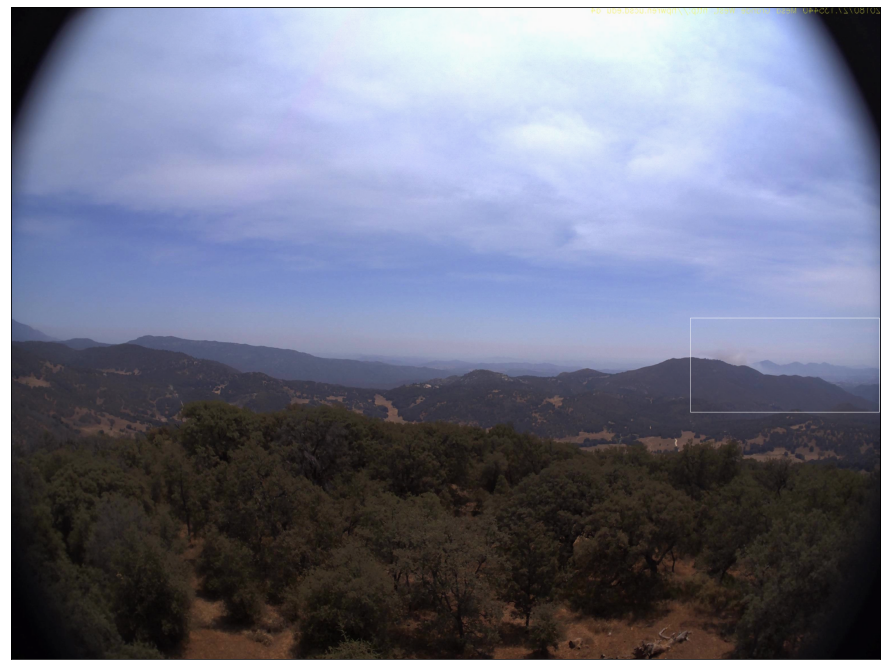

In [43]:
x = np.load('x.npy')[0]
# x = x.transpose(1,2,0)
# x = cv2.resize(x, (2016,1512))[-1512:]
# x = x.transpose(2,0,1)
x = torch.as_tensor(x*255, dtype=torch.uint8)

y = np.load('y.npy', allow_pickle=True)[0]['boxes']
y = torch.as_tensor(y)

i = torchvision.utils.draw_bounding_boxes(x, y)

show(i)

# Data Augmentations

TypeError: Image data of dtype object cannot be converted to float

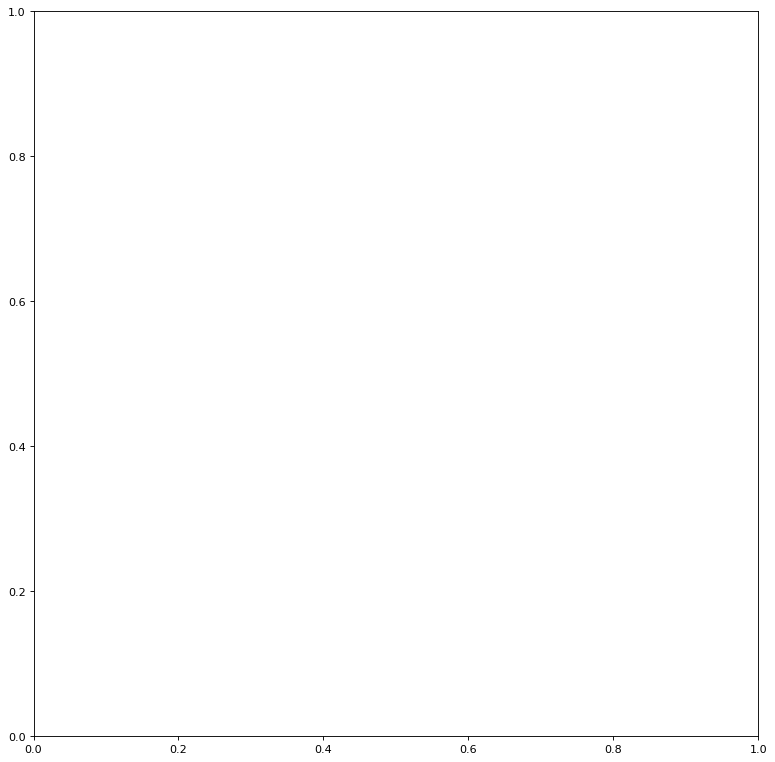

In [23]:
original_dimensions = (1536, 2048)
resize_dimensions = (1392, 1856)
crop_height = 1040
tile_dimensions = (224, 224)
tile_overlap = 20

img = cv2.imread(raw_data_path+example+'.jpg')
if img.shape[:2] != (1536, 2048):
    img = cv2.resize(img, (2048, 1536))

# Color Jitter
img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
img[:,:,0] = np.add(img[:,:,0], np.random.randn()*3, casting="unsafe")
img = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


# # Flip augment
# img = cv2.flip(img, 1)
    
# target_scale = np.random.uniform([0.5,0.6], [1.2,1])
# target_scale = [0.5, 1]
# print('target_scale:', target_scale)

# # Crop augment
# crop_scale = np.random.uniform(target_scale, [1.2,1])
# # crop_scale = np.array(target_scale)
# # crop_scale = np.array([1,1])
# print('crop_scale:', crop_scale)

# crop_size = np.round((crop_height, original_dimensions[1]) * crop_scale).astype(int)
# print('crop_size:', crop_size)

# crop_start = np.random.randint(0, original_dimensions-crop_size+1)
# print('crop_start:', crop_start)

# img = img[crop_start[0]:crop_start[0]+crop_size[0],crop_start[1]:crop_start[1]+crop_size[1]]

# # Resize augment
# resize_scale = target_scale / crop_scale
# print('resize_scale:', resize_scale)

# resize_size = np.round(crop_size*resize_scale).astype(int)
# print('resize_size:', resize_size)

# img = cv2.resize(img, (resize_size[1], resize_size[0]))

# Finish resizing
img = cv2.resize(img, (resize_dimensions[1], resize_dimensions[0]))
img = img[-(crop_height+50):50]

# Blur augment
# blur_size = np.random.randint(1,5)
# print('blur_size:', blur_size)
# img = cv2.blur(img, (blur_size,blur_size))

# Brightness-Contrast augment
img = cv2.convertScaleAbs(img, alpha=np.random.uniform(0.95,1.1), beta=np.random.randint(-100,0))
# img = img / 255
# img = (img - 0.5) / 0.5

plt.figure(figsize=(16, 12), dpi=80)
plt.imshow(img)


In [3]:
for i in range(20):
    print(224*i, 224+(i-1)*204)

0 20
224 224
448 428
672 632
896 836
1120 1040
1344 1244
1568 1448
1792 1652
2016 1856
2240 2060
2464 2264
2688 2468
2912 2672
3136 2876
3360 3080
3584 3284
3808 3488
4032 3692
4256 3896


In [9]:
r1 = 1536/2048
r2 = 1100/1536

In [14]:
1568/2048

0.765625

In [15]:
1536 * 0.765625


1176.0

In [16]:
1176.0 * r2

842.1875

1536x2048
1100x2048
crop above 1100


# CNN No Tile

In [182]:
i = torch.arange(36).unsqueeze(0)
print(i.view(6,6))
i = i.view(1, 2, 3, 2, 3)
i = torch.swapaxes(i, 2,3)
i = i.reshape(1, -1,3,3)
i

tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11],
        [12, 13, 14, 15, 16, 17],
        [18, 19, 20, 21, 22, 23],
        [24, 25, 26, 27, 28, 29],
        [30, 31, 32, 33, 34, 35]])


tensor([[[[ 0,  1,  2],
          [ 6,  7,  8],
          [12, 13, 14]],

         [[ 3,  4,  5],
          [ 9, 10, 11],
          [15, 16, 17]],

         [[18, 19, 20],
          [24, 25, 26],
          [30, 31, 32]],

         [[21, 22, 23],
          [27, 28, 29],
          [33, 34, 35]]]])

In [133]:
i = torch.arange(2*2*3*16).view(2, 2*4, 3*4)
i

tensor([[[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11],
         [ 12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23],
         [ 24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35],
         [ 36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47],
         [ 48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59],
         [ 60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71],
         [ 72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83],
         [ 84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95]],

        [[ 96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107],
         [108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119],
         [120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131],
         [132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143],
         [144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155],
         [156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167],
    

In [186]:
i = torch.arange(2*2*3*16).view(2, 2*4, 3*4)
i = i.view(2, 2, 4, 3, 4)
i = i.permute(1,3,0,2,4)
# i = torch.swapaxes(i, 2,3)

# i = torch.swapaxes(i, 0,2)


i.reshape(-1,2,4,4)

tensor([[[[  0,   1,   2,   3],
          [ 12,  13,  14,  15],
          [ 24,  25,  26,  27],
          [ 36,  37,  38,  39]],

         [[ 96,  97,  98,  99],
          [108, 109, 110, 111],
          [120, 121, 122, 123],
          [132, 133, 134, 135]]],


        [[[  4,   5,   6,   7],
          [ 16,  17,  18,  19],
          [ 28,  29,  30,  31],
          [ 40,  41,  42,  43]],

         [[100, 101, 102, 103],
          [112, 113, 114, 115],
          [124, 125, 126, 127],
          [136, 137, 138, 139]]],


        [[[  8,   9,  10,  11],
          [ 20,  21,  22,  23],
          [ 32,  33,  34,  35],
          [ 44,  45,  46,  47]],

         [[104, 105, 106, 107],
          [116, 117, 118, 119],
          [128, 129, 130, 131],
          [140, 141, 142, 143]]],


        [[[ 48,  49,  50,  51],
          [ 60,  61,  62,  63],
          [ 72,  73,  74,  75],
          [ 84,  85,  86,  87]],

         [[144, 145, 146, 147],
          [156, 157, 158, 159],
          [168, 169,

# Tiling

In [3]:
resize_dimensions = (1526, 2016)
crop_height = 1120
tile_dimensions = (224, 224)
series_length = 2
num_channels = 3
num_tiles_height, num_tiles_width = 5, 9
tile_overlap = 0

In [ ]:
img1 = np.arange(crop_height*resize_dimensions[1]*num_channels).reshape((crop_height,resize_dimensions[1],num_channels))
img2 = np.arange(crop_height*resize_dimensions[1]*num_channels, crop_height*resize_dimensions[1]*num_channels*2).reshape((crop_height,resize_dimensions[1],num_channels))

imgs = [img1, img2]

In [54]:
# Reshape
start = datetime.datetime.now()
x = []

for img in imgs:
    x.append(img)
    
x = np.transpose(np.stack(x), (0, 3, 1, 2))

x = np.reshape(x, (series_length, 3,
                               x.shape[2] // tile_dimensions[0], 
                               tile_dimensions[0], 
                               x.shape[3] // tile_dimensions[1],
                               tile_dimensions[1]))
x = x.swapaxes(3,4).reshape(series_length, 3, -1, tile_dimensions[0], tile_dimensions[1])
x = np.transpose(x, (2, 0, 1, 3, 4))

reshape_x = x
print(datetime.datetime.now()-start)

0:00:00.117873


In [64]:
# as_strided
start = datetime.datetime.now()
x = []

for img in imgs:
    bytelength = img.nbytes // img.size
    img = np.lib.stride_tricks.as_strided(img, 
                    shape=(num_tiles_height, 
                           num_tiles_width, 
                           tile_dimensions[0], 
                           tile_dimensions[1],
                           3), 
                    strides=(resize_dimensions[1]*(tile_dimensions[0]-tile_overlap)*bytelength*3,
                             (tile_dimensions[1]-tile_overlap)*bytelength*3, 
                             resize_dimensions[1]*bytelength*3, 
                             bytelength*3, 
                             bytelength), writeable=False)

    img = img.reshape((-1, tile_dimensions[0], tile_dimensions[1], 3))
    
    x.append(img.copy())
    
x = np.transpose(np.stack(x), (1, 0, 4, 2, 3))

strided_x = x
print(datetime.datetime.now()-start)

0:00:00.106012


In [45]:
(reshape_x != strided_x).sum()

0

In [70]:
# Sliding Window
start = datetime.datetime.now()
x = []

for img in imgs:
    x.append(img)
    
x = np.transpose(np.stack(x), (0, 3, 1, 2))

x = np.lib.stride_tricks.sliding_window_view(x, tile_dimensions, axis=(2,3), writeable=False)[:,:,::tile_dimensions[0]-tile_overlap, ::tile_dimensions[1]-tile_overlap]
x = x.reshape(series_length, 3, -1, tile_dimensions[0], tile_dimensions[1])
x = np.transpose(x, (2, 0, 1, 3, 4))

window_x = x
print(datetime.datetime.now()-start)

0:00:00.165752


In [47]:
(reshape_x != window_x).sum()

0

In [4]:
labels = np.arange(crop_height*resize_dimensions[1]).reshape((crop_height,resize_dimensions[1]))

In [5]:
# Reshape 
label = np.reshape(labels,(labels.shape[0] // tile_dimensions[0], 
                                    tile_dimensions[0], 
                                    labels.shape[1] // tile_dimensions[1],
                                    tile_dimensions[1]))
label = label.swapaxes(1,2).reshape(-1, tile_dimensions[0], tile_dimensions[1])

reshape_labels = label

In [10]:
# as_strided
bytelength = labels.nbytes // labels.size
label = np.lib.stride_tricks.as_strided(labels, 
                    shape=(num_tiles_height, 
                           num_tiles_width, 
                           tile_dimensions[0], 
                           tile_dimensions[1]), 
                    strides=(resize_dimensions[1]*(tile_dimensions[1]-tile_overlap)*bytelength,
                     (tile_dimensions[1]-tile_overlap)*bytelength,
                     resize_dimensions[1]*bytelength,
                     bytelength), writeable=False)
label = label.reshape(-1, tile_dimensions[0], tile_dimensions[1])

strided_labels = label

In [11]:
(reshape_labels != strided_labels).sum()

0

# Labels_Stats

In [3]:
resize_dimensions = (1526, 2060) # (1526, 2016)
crop_height = 1244 # 1120
tile_dimensions = (224, 224)
num_tiles_height, num_tiles_width = util_fns.calculate_num_tiles(resize_dimensions, crop_height, tile_dimensions, tile_overlap)
tile_overlap = 20



In [24]:
a = [(1545, 2060),(1392, 1856), (1239, 1652), (780, 1040)]
b = [1244,1040,1040, 632]

tile_dimensions = (224, 224)
tile_overlap = 20

dict_list = [{},{},{},{}]

for i, fire in enumerate(metadata['fire_to_images']):
    print(i)
    for image in metadata['fire_to_images'][fire]:
        p = labels_path + image + '.npy'
        if Path(p).exists() and image not in metadata['omit_no_xml']:
            original_labels = np.load(p)
            
            for i, (resize_dimensions, crop_height) in enumerate(zip(a, b)):
                labels = original_labels
                num_tiles_height, num_tiles_width = util_fns.calculate_num_tiles(resize_dimensions, crop_height, tile_dimensions, tile_overlap)
                labels = cv2.resize(labels, (resize_dimensions[1], resize_dimensions[0]))[-crop_height:] 
                labels = util_fns.tile_labels(labels, num_tiles_height, num_tiles_width, resize_dimensions, tile_dimensions, tile_overlap)
                labels = labels.sum((1,2))
                
                dict_list[i][image] = list(labels)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144


In [25]:
with open(f'./data/labels_stats_100overlap.pkl', 'wb') as pkl_file:
    pickle.dump(dict_list[0], pkl_file)
    
with open(f'./data/labels_stats_90overlap.pkl', 'wb') as pkl_file:
    pickle.dump(dict_list[1], pkl_file)
    
with open(f'./data/labels_stats_80overlap.pkl', 'wb') as pkl_file:
    pickle.dump(dict_list[2], pkl_file)
    
with open(f'./data/labels_stats_50overlap.pkl', 'wb') as pkl_file:
    pickle.dump(dict_list[3], pkl_file)

In [29]:
def calculate_pos_weight(labels_dict):
    tile_sums = []
    
    for image in labels_dict:
        x = np.array(labels_dict[image])
        tile_sums.extend(x)

    tile_sums = np.array(tile_sums)
    num_tiles = len(labels_dict[image])
    
    total_pos_tiles = len(tile_sums)
    total_neg_tiles = 144 * 40 * num_tiles 
    total_tiles = total_pos_tiles + total_neg_tiles

    smoke_threshold = 250
    target_tiles = len(tile_sums[tile_sums > smoke_threshold])

    neg_percent = (total_tiles - target_tiles) / total_tiles
    pos_weight = neg_percent / (1-neg_percent)
    
    return pos_weight

In [30]:
print('100% Overlap:', calculate_pos_weight(dict_list[0]))
print('90% Overlap:', calculate_pos_weight(dict_list[1]))
print('80% Overlap:', calculate_pos_weight(dict_list[2]))
print('50% Overlap:', calculate_pos_weight(dict_list[3]))

100% Overlap: 42.3658601791204
90% Overlap: 34.90835301062573
80% Overlap: 33.94022617124398
50% Overlap: 18.207815275310832


In [73]:
# No overlap, jitter, smoke_threshold = 250
print(pos_weight)

43.075400565504296


In [67]:
# Overlap, jitter, smoke_threshold = 250
print(pos_weight)

39.00135961930662


In [70]:
# Overlap, no jitter, smoke_threshold = 250
print(pos_weight)

36.241379310344755


# Save splits locally

In [8]:
train_list = np.loadtxt('/userdata/kerasData/data/new_data/mask_rcnn_preprocessed/20210420/train_list.txt', dtype=str)
val_list = np.loadtxt('/userdata/kerasData/data/new_data/mask_rcnn_preprocessed/20210420/val_list.txt', dtype=str)
test_list = np.loadtxt('/userdata/kerasData/data/new_data/mask_rcnn_preprocessed/20210420/test_list.txt', dtype=str)

train_fires = {util_fns.get_fire_name(item) for item in train_list}
val_fires = {util_fns.get_fire_name(item) for item in val_list}
test_fires = {util_fns.get_fire_name(item) for item in test_list}

train_split = util_fns.unpack_fire_images(metadata, train_fires)
val_split = util_fns.unpack_fire_images(metadata, val_fires)
test_split = util_fns.unpack_fire_images(metadata, test_fires, is_test=True)

np.savetxt('mask-rcnn-preprocessed_20210420_train-split.txt', train_split, fmt='%s')
np.savetxt('mask-rcnn-preprocessed_20210420_val-split.txt', val_split, fmt='%s')
np.savetxt('mask-rcnn-preprocessed_20210420_test-split.txt', test_split, fmt='%s')

# Test Metrics

In [40]:
pred = torch.as_tensor([1,1,1,1,1,1,1,1]).float()
gt = torch.as_tensor([0, 1, 0, 0, 0, 0, 0, 0]).float()
criterion = torch.nn.BCEWithLogitsLoss()
print(criterion(pred, gt))
torchvision.ops.focal_loss.sigmoid_focal_loss(pred, gt, reduction='mean')

tensor(1.1883)


tensor(3.6905)

In [57]:
np.load('/userdata/kerasData/src/pytorch-lightning-smoke-detection/lightning_logs/MobileNetV3LargeBCE/version_4/tile_preds/20170520_FIRE_lp-s-iqeye/1495305674_+01320.npy')

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1], dtype=int32)

In [70]:
# pred = [1,1,1,0,1,1,0,1]
pred = [0,1,0,0,0,0,0,0]
# pred = [0,0,0,0,0,0,0,0]
gt = [0, 1, 0, 0, 0, 0, 1, 0]

print(sklearn.metrics.accuracy_score(pred, gt)) # tensor([0.2857, 1.0000], device='cuda:0')
print(sklearn.metrics.precision_score(pred, gt)) # tensor([1.0000, 0.1667], device='cuda:0')
print(sklearn.metrics.recall_score(pred, gt)) # tensor([0.2857, 1.0000], device='cuda:0')
print(sklearn.metrics.f1_score(pred, gt)) # tensor([0.4444, 0.2857], device='cuda:0')

pred = torch.as_tensor(pred)
gt = torch.as_tensor(gt)

print(torchmetrics.Accuracy()(pred, gt))
print(torchmetrics.Recall(multiclass=False)(pred, gt))
print(torchmetrics.Precision(multiclass=False)(pred, gt))
print(torchmetrics.F1(multiclass=False)(pred, gt))


0.875
0.5
1.0
0.6666666666666666
tensor(0.8750)
tensor(0.5000)
tensor(1.)
tensor(0.6667)


In [101]:
torch.Tensor([[1,2,3], [4,5,6]])[:,0]

tensor([1., 4.])

In [44]:
fire_preds = np.random.randint(0,2,(13, 81))
fire_preds = torch.from_numpy(fire_preds).int()
negative_preds = fire_preds[:,:40]
positive_preds = fire_preds[:,40:]

In [52]:
negative_preds = torch.zeros((13,40))
negative_preds[0,3] = 1

# Negative accuracy
torchmetrics.functional.accuracy(negative_preds, torch.zeros(negative_preds.shape).int())

tensor(0.9981)

In [53]:
# Negative accuracy by fire
torchmetrics.functional.accuracy(negative_preds, torch.zeros(negative_preds.shape).int(), subset_accuracy=True)

tensor(0.9231)

In [100]:
positive_preds = torch.ones((13,40))
positive_preds[0,0] = 0
positive_preds[0,1] = 0
positive_preds[1,0] = 0
positive_preds[1,2] = 0

# Positive accuracy
torchmetrics.functional.accuracy(positive_preds, torch.ones(positive_preds.shape).int())



tensor(0.9923)

In [90]:
# Positive accuracy by fire
torchmetrics.functional.accuracy(positive_preds, torch.zeros(positive_preds.shape).int(), subset_accuracy=True)



tensor(0.)

In [91]:
# Positive accuracy by time
positive_preds.sum(dim=0)/positive_preds.shape[0]



tensor([0.8462, 0.9231, 0.9231, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000])

In [92]:
# Positive cumulative accuracy by time
cumulative_preds = (positive_preds.cumsum(dim=1) > 0).int()

cumulative_preds.sum(dim=0)/cumulative_preds.shape[0]



tensor([0.8462, 0.9231, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000])

In [98]:
# Average time-to-detection

indices = cumulative_preds * torch.arange(cumulative_preds.shape[1], 0, -1)
indices = torch.argmax(indices, 1, keepdim=True)
indices.float().mean()

tensor(0.2308)

# Model

| Model             | Accuracy | # of Params |
|-------------------|----------|-------------|
| ResNet50          | 76.130   | 25.55       |
| MobileNetV3 Large | 74.042   | 5.48        |
| ResNeXt-50-32x4d  | 77.618   | 25.02       |
| MNASNet 1.0       | 73.456   | 4.38        |
|                   |          |             |

In [4]:
def count_parameters(model): 
    return sum(p.numel() for p in model.parameters() if p.requires_grad) / 1000000

In [6]:
# model = torchvision.models.mnasnet0_5(pretrained=False)
model = EfficientNet.from_name("efficientnet-b3")
count_parameters(model)

12.233232

In [3]:
deit_model = transformers.DeiTModel.from_pretrained('facebook/deit-tiny-distilled-patch16-224')

Some weights of the model checkpoint at facebook/deit-tiny-distilled-patch16-224 were not used when initializing DeiTModel: ['cls_classifier.weight', 'cls_classifier.bias', 'distillation_classifier.weight', 'distillation_classifier.bias']
- This IS expected if you are initializing DeiTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DeiTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DeiTModel were not initialized from the model checkpoint at facebook/deit-tiny-distilled-patch16-224 and are newly initialized: ['deit.pooler.dense.weight', 'deit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference

In [4]:
batch_size=1
num_tiles=60
series_length=4
num_channels=3
height=224
width=224

x = torch.randn((batch_size* num_tiles*series_length, num_channels, height, width))
output = deit_model(x)

output.last_hidden_state.shape

torch.Size([240, 198, 192])

In [6]:
output.last_hidden_state[:,0,:].shape

torch.Size([240, 192])

In [8]:
_avg_pooling = nn.AdaptiveAvgPool2d(1)
output2 = _avg_pooling(x)
output2.shape

torch.Size([2, 3, 1, 1])

In [11]:
model = EfficientNet.from_name("efficientnet-b7")
x = torch.randn((batch_size* num_tiles*series_length, num_channels, height, width))
output = model(x)
output.shape

torch.Size([2, 2560, 1, 1])

# Fire Label Statistics

In [20]:
metadata = pickle.load(open('/userdata/kerasData/data/new_data/batched_tiled_data/metadata.pkl', 'rb'))

train = [item[45:-4] for item in np.loadtxt('/userdata/kerasData/data/new_data/mask_rcnn_preprocessed/20210420/train_list.txt', dtype=str)]
val = [item[45:-4] for item in np.loadtxt('/userdata/kerasData/data/new_data/mask_rcnn_preprocessed/20210420/val_list.txt', dtype=str)]
test = [item[45:-4] for item in np.loadtxt('/userdata/kerasData/data/new_data/mask_rcnn_preprocessed/20210420/test_list.txt', dtype=str)]

selected_images = []
selected_images.extend(train)
selected_images.extend(val)
selected_images.extend(test)

In [24]:
l = []
for fire in metadata['fire_to_images']:
    if len(metadata['fire_to_images'][fire]) != 81:
        l.append(fire)
        print(fire, len(metadata['fire_to_images'][fire]))

20160718_FIRE_mg-s-iqeye 41
20190620_FIRE_smer-tcs9-mobo-c 72
20191006_FIRE_lp-e-mobo-c 72
20190716_Riverfire_rm-w-mobo-c 80
20171207_FIRE_bh-w-mobo-c 77
20180809_FIRE_bh-s-mobo-c 80
20170520_FIRE_om-s-mobo-c 55
20190716_FIRE_so-w-mobo-c 72
20181112_house_wc-n-mobo-c 71
20170807_FIRE_bh-n-mobo-c 78
20190712_RockHouse_wc-e-mobo-c 79
20160619_FIRE_lp-e-iqeye 41
20190805_FIRE_sp-e-mobo-c 77
20160722_FIRE_mg-s-iqeye 41
20190629_FIRE_hp-n-mobo-c 57
20180806_Holy_sp-s-mobo-m 73
20190803_Sage_om-n-mobo 73
20171017_FIRE_smer-tcs3-mobo-c 78
20170713_FIRE_smer-tcs8-mobo-c 77
20191003_FIRE_smer-tcs9-mobo-c 77
20190803_OtaySouth_lp-s-mobo 79
20170711_FIRE_bm-s-mobo-c 64
20190716_Meadowfire_hp-n-mobo-c 70
20190728_Dehesa_lp-n-mobo 80
20170708_Whittier_syp-n-mobo-m 80
20180806_Holy_sp-s-mobo-c 72
20191006_FIRE_lp-n-mobo-c 73
20191006_FIRE_lo-w-mobo-c 80
20190728_FIRE_om-n-mobo-c 79
.ipynb_checkpoints 0
20190825_FIRE-smer-tcs8-mobo-c 80
20190826_FIRE_pi-s-mobo-c 80
20180706_FIRE_sm-n-mobo-c 70
201807

In [25]:
len(l)

34

### Full data

In [2]:
# Total fires
metadata['num_fires']

148

In [3]:
# Total images
metadata['num_images']

11581

In [4]:
# Num positive images
gt = np.array(list(metadata['ground_truth_label'].values()))
gt.sum()

5839

In [5]:
# Num images with XML files
xml = np.array(list(metadata['has_xml_label'].values()))
xml.sum()

5112

In [6]:
# Num fires with missing XML files
bad_fires = set()
for image in metadata['ground_truth_label'].keys():
    if metadata['ground_truth_label'][image] != metadata['has_xml_label'][image]:
        bad_fires.add(image.split('/')[0])
        
len(bad_fires)

88

In [7]:
# Num images with at least 1 tile positive
xml = np.array(list(metadata['has_positive_tile'].values()))
xml.sum()

4626

### Subset data

In [79]:
# Total fires
all_fires = set()

for image in selected_images:
    all_fires.add(image.split('/')[0])
    
len(all_fires)

147

In [78]:
# Total subset images
len(selected_images)

5631

In [81]:
# Num positive images 
gt = [metadata['ground_truth_label'][image] for image in selected_images]
sum(gt)

5112

In [82]:
# Num images with XML files
xml = [metadata['has_xml_label'][image] for image in selected_images]
sum(xml)

5112

# Tensorboard

In [4]:
experiment_id = "KCp0QrxWTmaMZlIV0eGBMQ"
experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
df = experiment.get_scalars()
df

,run,tag,step,value
0,.,epoch,0,0.000000
1,.,epoch,1,0.000000
2,.,epoch,2,0.000000
3,.,epoch,3,0.000000
4,.,epoch,4,0.000000
5,.,epoch,5,1.000000
6,.,epoch,6,1.000000
7,.,epoch,7,1.000000
8,.,epoch,8,1.000000
9,.,epoch,9,1.000000


# Load Image Speed

In [299]:
from PIL import Image

# color_jitter = T.ColorJitter(brightness=0.2, contrast=0.2)
# gaussian_blur = T.GaussianBlur(kernel_size=(9, 9), sigma=(5, 5))
# horizontal_flip = T.RandomHorizontalFlip(p=1)
resize = T.Resize((1536, 2016))

start = datetime.datetime.now()
now = datetime.datetime.now()

image_name = '/userdata/kerasData/data/new_data/raw_images/20180504_FIRE_smer-tcs8-mobo-c/1525469995_+00360.jpg'


### Load X
x = []

for _ in range(2):
    img = Image.open(image_name)
    img = img.resize((1536, 2016))
    x.append(img)

# x = torch.stack(x)/255

print('Load X: ', datetime.datetime.now()-now)
now = datetime.datetime.now()

### Load Labels
label_path = '/userdata/kerasData/data/new_data/drive_clone_torch/20180504_FIRE_smer-tcs8-mobo-c/1525469995_+00360.pt'
if Path(label_path).exists():
    labels = torch.load(label_path)
    labels = resize(labels.unsqueeze(0))[:,-1344:].squeeze(0)
else:
    labels = torch.zeros(x.shape[2:])

print('Load Labels: ', datetime.datetime.now()-now)
now = datetime.datetime.now()

### Data Augmentation
# x = color_jitter(x)
# x = gaussian_blur(x)

# if torch.rand(1) > 0.5:
#     x = horizontal_flip(x)
#     labels = horizontal_flip(labels)

# x = x/255

# print('Data Augment: ', datetime.datetime.now()-now)
# now = datetime.datetime.now()
    
### Tile Image
if True:
    # x.shape = [54, 5, 3, 224, 224]
    # labels.shape = [54, 224, 224]
    x = x.view((-1, 2, 3, 224, 224))
    labels = labels.view((-1, 224, 224))
    labels = (labels.sum(dim=(1,2)) > 10).float()
else:
    # Pretend as if tile size = image size
    x = x.unsqueeze(0)
    labels = labels.unsqueeze(0)
    
# plt.imshow(x[0].permute((1,2,0))) 
print('Tile Image: ', datetime.datetime.now()-now)

print('Total: ', datetime.datetime.now()-start)

Load X:  0:00:00.504471
Load Labels:  0:00:00.163245


AttributeError: 'list' object has no attribute 'view'

In [358]:
# color_jitter = T.ColorJitter(brightness=0.2, contrast=0.2)
# gaussian_blur = T.GaussianBlur(kernel_size=(9, 9), sigma=(5, 5))
# horizontal_flip = T.RandomHorizontalFlip(p=1)
resize = T.Resize((1536, 2016))

start = datetime.datetime.now()
now = datetime.datetime.now()

image_name = '/userdata/kerasData/data/new_data/raw_images/20180504_FIRE_smer-tcs8-mobo-c/1525469995_+00360.jpg'


### Load X
x = []

for _ in range(2):
    img = torchvision.io.read_image(image_name)
    img = resize(img)[:,-1344:]
    x.append(img)

x = torch.stack(x)/255

print('Load X: ', datetime.datetime.now()-now)
now = datetime.datetime.now()

### Load Labels
label_path = '/userdata/kerasData/data/new_data/drive_clone_torch/20180504_FIRE_smer-tcs8-mobo-c/1525469995_+00360.pt'
if Path(label_path).exists():
    labels = torch.load(label_path)
    labels = resize(labels.unsqueeze(0))[:,-1344:].squeeze(0)
else:
    labels = torch.zeros(x.shape[2:])

print('Load Labels: ', datetime.datetime.now()-now)
now = datetime.datetime.now()

### Data Augmentation
# x = color_jitter(x)
# x = gaussian_blur(x)

# if torch.rand(1) > 0.5:
#     x = horizontal_flip(x)
#     labels = horizontal_flip(labels)

# x = x/255

# print('Data Augment: ', datetime.datetime.now()-now)
# now = datetime.datetime.now()
    
### Tile Image
if True:
    # x.shape = [54, 5, 3, 224, 224]
    # labels.shape = [54, 224, 224]
    x = x.view((-1, 2, 3, 224, 224))
    labels = labels.view((-1, 224, 224))
    labels = (labels.sum(dim=(1,2)) > 10).float()
else:
    # Pretend as if tile size = image size
    x = x.unsqueeze(0)
    labels = labels.unsqueeze(0)
    
# plt.imshow(x[0].permute((1,2,0))) 
print('Tile Image: ', datetime.datetime.now()-now)

print('Total: ', datetime.datetime.now()-start)

Load X:  0:00:00.931444
Load Labels:  0:00:00.323898
Tile Image:  0:00:00.090448
Total:  0:00:01.360604


In [24]:
start = datetime.datetime.now()
now = datetime.datetime.now()

file_name = '20170711_FIRE_bl-e-mobo-c/1499807631_+01500'

should_flip = np.random.rand() > 0.5
blur_size = int(np.random.randn()*3+10)
        
### Load Images
x = []

for _ in range(2):
    img = cv2.imread(raw_data_path+'/'+file_name+'.jpg') # img.shape = [height, width, num_channels]
    img = cv2.resize(img, (2016, 1536))[-1344:]
    img = cv2.flip(img, 1)
    img = cv2.blur(img, (blur_size,blur_size))
    x.append(img)

x = np.transpose(np.stack(x), (0, 3, 1, 2)) #/ 255 # Normalize by /255 (good enough normalization)

print('Load X: ', datetime.datetime.now()-now)
now = datetime.datetime.now()

### Load Labels
label_path = labels_path+'/'+file_name+'.npy'
if Path(label_path).exists():
    labels = np.load(label_path)
else:
    labels = np.zeros(x[0].shape[:2], dtype=np.uint8) 

labels = cv2.resize(labels, (2016, 1536))[-1344:]
labels = cv2.flip(labels, 1)

# print('Load Labels: ', datetime.datetime.now()-now)
# now = datetime.datetime.now()


# ### Tile Image
# if True:
#     x = np.reshape(x, (-1, 2, 3, 224, 224))
#     labels = np.reshape(labels,(-1, 224, 224))
#     labels = (labels.sum(axis=(1,2)) > 10).astype(float)
# else:
#     # Pretend as if tile size = image size
#     x = np.expand_dims(x, 0)
#     labels = np.expand_dims(labels, 0)

# print('Tile Image: ', datetime.datetime.now()-now)
    
# print('Total: ', datetime.datetime.now()-start)

Load X:  0:00:00.229176


# JPG Load Comparison

In [161]:
np.load('/userdata/kerasData/data/new_data/pytorch_lightning_data/embeddings/cnn_embeddings/20160619_FIRE_om-e-mobo-c/1466360737_+01380.npy').shape

(45, 1, 960)

In [44]:
from turbojpeg import TurboJPEG
jpeg = TurboJPEG()

image_name = raw_data_path + '/20180504_FIRE_smer-tcs8-mobo-c/1525469995_+00360.jpg'

now = datetime.datetime.now()
x = jpeg.decode(open(image_name, 'rb').read())

print(datetime.datetime.now()-now)

0:00:00.045543


In [54]:
from PIL import Image

now = datetime.datetime.now()
x = np.array(Image.open(image_name))
print(datetime.datetime.now()-now)

0:00:00.119051


In [22]:
now = datetime.datetime.now()
image_name = raw_data_path + '/20180504_FIRE_smer-tcs8-mobo-c/1525469995_+00360.jpg'
x = cv2.imread(image_name)
x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)

print(datetime.datetime.now()-now)

0:00:00.166182


In [55]:
now = datetime.datetime.now()
image_name = raw_data_path + '/20180504_FIRE_smer-tcs8-mobo-c/1525469995_+00360.jpg'
x = torchvision.io.read_image(image_name)

print(datetime.datetime.now()-now)

0:00:00.039816


In [28]:
now = datetime.datetime.now()
image_name = labels_path + '/20180504_FIRE_smer-tcs8-mobo-c/1525469995_+00360.npy'
x = np.load(image_name)

print(datetime.datetime.now()-now)

0:00:00.006493
